<a href="https://colab.research.google.com/github/PapaJacque16/CS-450-Capstone/blob/main/PCR%2C_Optimization%2C_and_Prediction_of_Sensor_Faults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Principle Component Regression
#### Quality related process monitoring for the system.

In [32]:
#Initial Set Up - Import all necessary Libraries and mount to gdrive to import dataset, then perform train test split.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/CS450/Sensor_Time_Series.csv')
df

,Time_Series,Sensor_1_Range,Sensor_2_Range,Temp_High,Temp_Low,Performance
0,3/21/22 0:00,12.162611,13.816756,190.17,139.47,49.045854
1,3/21/22 0:01,12.252904,14.100229,187.41,139.48,46.082675
2,3/21/22 0:02,12.171030,13.981956,190.71,139.66,49.239073
3,3/21/22 0:03,12.121374,13.939545,190.89,139.84,49.231828
4,3/21/22 0:04,12.087014,14.058108,191.02,139.86,49.188905
...,...,...,...,...,...,...
10075,3/27/22 23:55,12.686857,14.204982,191.49,140.67,49.301875
10076,3/27/22 23:56,12.651416,14.201341,191.48,140.78,49.150075
10077,3/27/22 23:57,12.638795,13.897180,191.41,140.80,49.351615
10078,3/27/22 23:58,12.575106,13.997841,191.43,140.74,49.267265


In [11]:
X =  df[['Sensor_1_Range',	'Sensor_2_Range',	'Temp_Low']]
y = df['Temp_High']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=32)

In [13]:
#Before we can run Principle Component Regression we have to standardize the features to be the same scale then we can generate the components.
#Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [14]:
#Run baseline regression models - Benchmarks for comparison, using 3 baseline models- Linear Regression, Lasso Regression, and Ridge Regression.
#Define cross validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [15]:
#Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

In [16]:
#Lasso Regression
lasso_reg = LassoCV().fit(X_train_scaled, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

In [17]:
#Ridge Regression
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

In [18]:
#Generate Principle Components- generated from sklearn.decomposition
pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train_scaled)

#View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

,0,1,2
0,0.703490,-0.042489,0.709434
1,0.691833,-0.187566,-0.697270
2,0.162692,0.981333,-0.102555


In [19]:
#View explained variance ratio for each principle component
pca.explained_variance_ratio_

array([0.37963436, 0.33255794, 0.2878077 ])

From the above, we can see that the first principal component (PC1) captures overall 38% of the variance followed by PC2 with a 3.46% variance.

In [20]:
#Determine the number of Principle Components
#Initialize linear regression instance
lin_reg = LinearRegression()

In [21]:
#Create empty list to store RMSE for each iteration
rmse_list = []

In [22]:
#Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

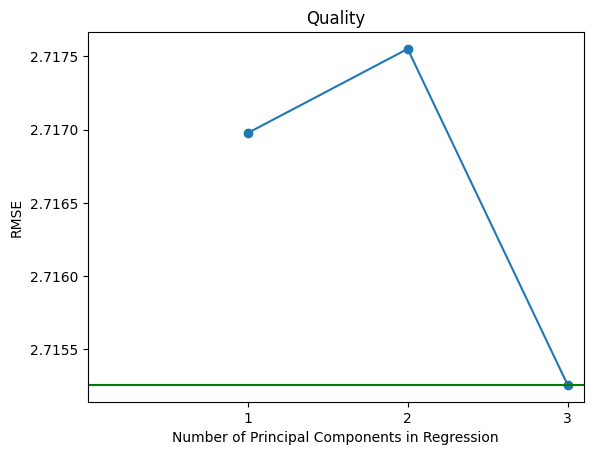

In [23]:
#Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

##Results 
The PCR is telling us that based on the quality related process monitoring for the system being used that the smaller number of principal components represents most of the variability in the data and (presumptively) the relationship with the target variable. In this case the quality from PC1 to PC3 varies less than 0.002.

##Optimization
####Identifying faults that have occured based on sensor measurments of the system's performance. 

The variance is the second most important measure of a probability distribution, after the mean. It quantifies the spread of the outcomes of a probability distribution. Since hypothesis tests use the probability distributions of these test statistics to calculate p-values. 

In [33]:
np.random.seed(1)

n = 10080
m = 1015
p = 0.002
snr = 5

sigma = np.sqrt(p*n/(snr**2))
A = np.random.randn(m,n)

x_true = (np.random.rand(n) <= p).astype(int)
v = sigma*np.random.randn(m)

y = A.dot(x_true) + v

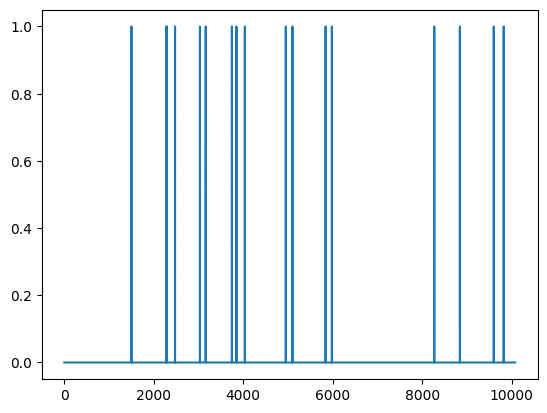

In [25]:
plt.plot(range(n),x_true);

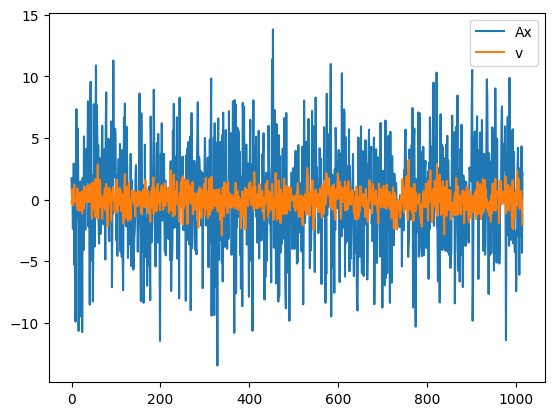

In [26]:
plt.plot(range(m), A.dot(x_true),range(m),v)
plt.legend(('Ax','v'));

We solve the relaxed maximum likelihood problem with CVXPY and then round the result to get a Boolean solution.

In [27]:
%%time
import cvxpy as cp
x = cp.Variable(shape=n)
tau = 2*cp.log(1/p - 1)*sigma**2
obj = cp.Minimize(cp.sum_squares(A*x - y) + tau*cp.sum(x))
const = [0 <= x, x <= 1]
cp.Problem(obj,const).solve(verbose=True)
print("final objective value: {}".format(obj.value))

# relaxed ML estimate
x_rml = np.array(x.value).flatten()

# rounded solution
x_rnd = (x_rml >= .5).astype(int)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 03 10:05:00 PM: Your problem has 10080 variables, 2 constraints, and 0 parameters.
(CVXPY) Apr 03 10:05:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 10:05:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 10:05:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 10:05:00 PM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 03 10:05:00 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Apr 03 10:05:08 PM: Applying reduction OSQP
(CVXPY) Apr 03 10:05:10 PM: Finished problem compilation (took 9.678e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 03 10:05:10 PM: Invoking solver OSQP  to obtain a solution.
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 11095, constraints m = 21175
          nnz(P) + nnz(A) = 10253390
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.

/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Evaluation: We define a function for computing the estimation errors, and a function for plotting  𝑥 , the relaxed ML estimate, and the rounded solutions.

In [28]:
import matplotlib

def errors(x_true, x, threshold=.5):
    '''Return estimation errors.
    
    Return the true number of faults, the number of false positives, and the number of false negatives.
    '''
    n = len(x_true)
    k = sum(x_true)
    false_pos = sum(np.logical_and(x_true < threshold, x >= threshold))
    false_neg = sum(np.logical_and(x_true >= threshold, x < threshold))
    return (k, false_pos, false_neg)

def plotXs(x_true, x_rml, x_rnd, filename=None):
    '''Plot true, relaxed ML, and rounded solutions.'''
    matplotlib.rcParams.update({'font.size': 14})
    xs = [x_true, x_rml, x_rnd]
    titles = ['x_true', 'x_rml', 'x_rnd']

    n = len(x_true)
    k = sum(x_true)

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))

    for i,x in enumerate(xs):
            ax[i].plot(range(n), x)
            ax[i].set_title(titles[i])
            ax[i].set_ylim([0,1])
            
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
    return errors(x_true, x_rml,.5)

(17, 0, 0)

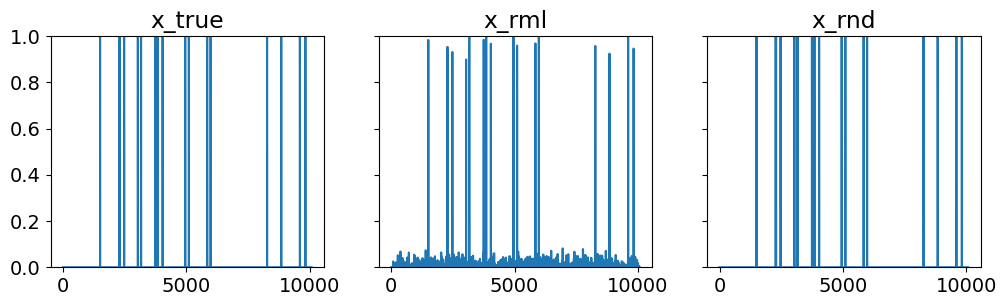

In [29]:
plotXs(x_true, x_rml, x_rnd, 'fault.pdf')

Out of the evaluation, we found that there was a total of 17 sensor fault issues detected, an the solutions recovery has 0 false negatives and 0 false positives.

##Prediction
####Predictors are data features that are inputs to calculate a predicted output, and in this scenario finding the coefficients requires the solution of an optimization problem. In machine learning the data inputs are called features and the measured outputs are called labels.
####Regression is the method of adjusting parameters in a model to minimize the difference between the predicted output and the measured output.

In [36]:
from scipy.optimize import minimize

In [40]:
df = pd.read_csv('/content/gdrive/MyDrive/CS450/Sensor_Time_Series.csv')
df

,Time_Series,Sensor_1_Range,Sensor_2_Range,Temp_High,Temp_Low,Performance
0,3/21/22 0:00,12.162611,13.816756,190.17,139.47,49.045854
1,3/21/22 0:01,12.252904,14.100229,187.41,139.48,46.082675
2,3/21/22 0:02,12.171030,13.981956,190.71,139.66,49.239073
3,3/21/22 0:03,12.121374,13.939545,190.89,139.84,49.231828
4,3/21/22 0:04,12.087014,14.058108,191.02,139.86,49.188905
...,...,...,...,...,...,...
10075,3/27/22 23:55,12.686857,14.204982,191.49,140.67,49.301875
10076,3/27/22 23:56,12.651416,14.201341,191.48,140.78,49.150075
10077,3/27/22 23:57,12.638795,13.897180,191.41,140.80,49.351615
10078,3/27/22 23:58,12.575106,13.997841,191.43,140.74,49.267265


In [42]:
df.columns

Index(['Time_Series', 'Sensor_1_Range', 'Sensor_2_Range', 'Temp_High',
       'Temp_Low', 'Performance '],
      dtype='object')

In [43]:
xm1 = np.array(df["Sensor_1_Range"]) # Ranges for Sensor 1
xm2 = np.array(df["Sensor_2_Range"]) # Ranges for Sensor 2 
xm3 = np.array(df["Temp_High"]) # High Temp 
ym = np.array(df["Performance "])# Performance of the System

####The Objective Funciton is formalized

In [47]:
# calculate y
# XM1, XM2, XM3 are the different factors we are using 
def calc_y(x):
  a = x[0] 
  b = x[1] 
  c = x[2] 
  d = x[3]
#begin regression modeling by using y equals a times (xm1 to the power of b......)
  y = a * ( xm1 ** b ) * ( xm2 ** c ) * ( xm3 ** d ) 
  return y

In [48]:
# define objective using the function
def objective(x): 
  # calculate y 
  y = calc_y(x)
  # calculate objective
  obj = 0.0
  for i in range(len(ym)): # i is the row, and ym is the measurement of y.
      obj = obj + ((y[i]-ym[i])/ym[i])**2 
  # return result
  return obj

####You have to adjust the unknown parameters (a, b, c, d) to minimize the sum of squared errors of the normalized difference between the measured and predicted value. You have to normalize the difference by the measured value before it is squared.

In [75]:
 # For my final guesses I chose 0.9 for examples to test the results
x0 = np.zeros(4) 
x0[0] = 0.4 # a 
x0[1] = 0.4 # b 
x0[2] = 0.4 # c 
x0[3] = 0.4 # d

In [76]:
# Show the initial objective
print('Initial Objective:' + str(objective(x0)))

Initial Objective:2327.937596911347


In [77]:
# Optimization
# Bounds on the variables
my_bnds = (-10.0, 10.0)
bnds = (my_bnds, my_bnds, my_bnds, my_bnds)
#Minimize a scalar function of one or more variables
#Using Sequential Least Squares Programming (SLSQP), a method to constrain minimalization 
solution = minimize(objective, x0, method='SLSQP', bounds=bnds)
x = solution.x
y = calc_y(x)

In [78]:
# Show the final objective
cObjective = 'Final Objective: ' + str(objective(x)) 
print(cObjective)
# Print the solution
print('Solution')
cA = 'A = ' + str(x[0]) 
print(cA)
cB = 'B = ' + str(x[1]) 
print(cB)
cC = 'C = ' + str(x[2]) 
print(cC)
cD = 'D = ' + str(x[3]) 
print(cD)

Final Objective: 6.662583254444616
Solution
A = 0.04683912374729387
B = 0.17198379492910917
C = -0.9448335327807761
D = 1.7168458714334531


In [79]:
cFormula = "Formula is : " + "\n" \
          + "A * Sensor_1_Range^B * Sensor_1_Range^C * Temp_High^D"
cLegend = cFormula + "\n" + cA + "\n" + cB + "\n" \
           + cC + "\n" + cD + "\n" + cObjective

####Where n is the number of data points, i is an index for the current measured value, pred is the predicted value, and meas is the measured value. Report the parameter values, the R2 value of fit, and display a plot of the results.

In [80]:
#ym is the measured outcome
#y is the predicted outcome
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(ym,y)
r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2) 
print(cR2)

R^2 correlation = 0.8227418175189328


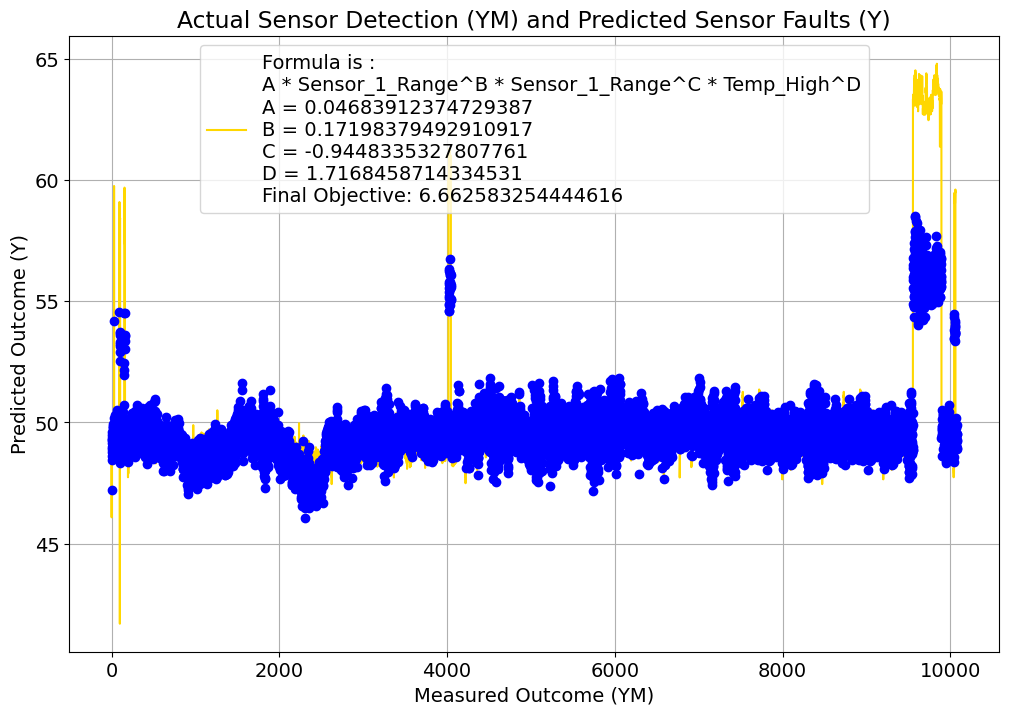

In [81]:
plt.figure(figsize=(12, 8))
plt.title('Actual Sensor Detection (YM) and Predicted Sensor Faults (Y)') 
plt.plot(ym,'gold' ,y,'bo')
plt.xlabel('Measured Outcome (YM)') #Gold Curve 
plt.ylabel('Predicted Outcome (Y)') #Blue Dots 
plt.legend([cLegend])
plt.grid(True)
plt.show()

The results showed us that the relationship between the independent and dependent variables was most closely aligned when our test data for a,b,c, and d was and the tests were set to 0.4. I used various other test sample sizes and the best results came from this sample size. This resulted in our Initial Objective: 2327.937596911347 and the Final Objective: 6.662583254444616 the resulting correlation (R^2 correlation) = 0.8227418175189328.